# Competition site
- http://www.kaybensoft.com/dublinr/10_competition_site.html

# Imports

In [1]:
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

# Constants

In [2]:
total_budget = 50000000
gold_price = 1500 # dollars per ounce

# Data Loading

## - Costs Data

In [3]:
costs_data = pd.read_csv("data/costs_data.csv")
costs_data.head()

,gold_amount,low,med,high
0,0,0,0,0
1,2000,964000,882000,768000
2,4000,1868000,1734000,1359000
3,6000,2729000,2565000,1861000
4,8000,3559000,3380000,2323000


## - Elevation Data

In [4]:
elevation_data = pd.read_csv("data/elevation_data.csv")
elevation_data.head()

,parcel_id,Easting,Northing,elevation
0,1,0.50,0.50,434.65
1,2,1.50,0.50,709.21
2,3,2.50,0.50,1000.25
3,4,3.50,0.50,296.81
4,5,4.50,0.50,412.29


## - Sample Data
- Parcels that have already been auctioned and exploited (see the gold_available column)
- Why are the Northing and Eastig shifted by .5?

In [5]:
sample_data = pd.read_csv("data/sample_data.csv")
sample_data.head()

,parcel_id,Easting,Northing,Pyerite,Mexallon,Tritanium,Megacyte,Nocxium,Isogen,Veldspar,Plagioclase,Hedbergite,Spudumain,Gneiss,Arkonor,Mercoxit,Bistot,Crokite,gold_available
0,4,3.50,0.50,133.27,108.26,95.88,129.70,111.15,138.74,109.82,148.30,130.35,145.60,114.18,105.52,107.60,94.12,108.02,3901.52
1,9,8.50,0.50,144.45,110.17,97.84,104.66,104.43,123.08,104.58,117.52,128.96,126.25,119.67,116.79,109.63,130.86,113.13,17523.53
2,11,10.50,0.50,145.70,110.63,116.20,158.60,118.84,109.34,98.57,148.77,129.75,149.73,119.89,103.67,114.77,119.50,106.39,4537.82
3,14,13.50,0.50,126.26,116.73,120.17,116.64,127.24,103.68,117.29,101.20,191.69,178.01,138.92,101.05,107.52,104.59,105.25,21601.11
4,17,16.50,0.50,107.38,98.94,120.78,98.77,119.90,121.31,121.41,167.34,158.55,178.47,131.63,109.36,101.88,111.56,104.27,21186.86


## - Auction Parcels
- The objective is to figure out on which of these to bid and how much

In [6]:
auction_parcels = pd.read_csv("data/auction_parcels.csv")
auction_parcels.head()

,parcel_id,Easting,Northing,elevation,Arkonor,Mercoxit,Bistot,Crokite
0,515,64.50,3.50,23.19,107.21,101.98,105.71,102.50
1,914,13.50,6.50,784.99,102.44,104.95,108.83,109.35
2,1538,37.50,10.50,1258.73,103.50,111.47,105.55,98.07
3,1790,139.50,11.50,474.18,102.07,109.97,105.21,104.42
4,2416,15.50,16.50,1584.86,114.48,116.99,113.14,108.81


# Fixed costs calculator

In [7]:
def fixed_cost(row): 
    if row["elevation"]  < 0: 
        return 4000000.0 
    elif row["elevation"] > 0 and row["elevation"]  <= 500: 
        return 3000000.0
    else:
        return 8000000.0

# Variable costs calculator
- Use a simple linear regression

In [8]:
from sklearn import linear_model

regressions = {}
for elevation in ["low", "med", "high"]:
    regression = linear_model.LinearRegression()
    regression.fit(costs_data.loc[:, ["gold_amount"]], costs_data.loc[:,elevation])
    regressions[elevation] = regression

def variable_cost(row):
    if row["elevation"] < 0: 
        return regressions['low'].predict(row["elevation"])[0]
    elif row["elevation"] >= 0 and row["elevation"] <= 700: 
        return regressions['med'].predict(row["elevation"])[0]
    else:
        return regressions['high'].predict(row["elevation"])[0]

# Estimate the average amount of gold under each biddable parcel
- Naive approach: average the known quantities of gold in a circle of a given radius around each parcel
- Use the smallest circle radius for which the gold amount estimations start to increase monotonically
    - run the algorithm `for radius in range(1, 10)` and eyeball a decent value

<IPython.core.display.Javascript object>


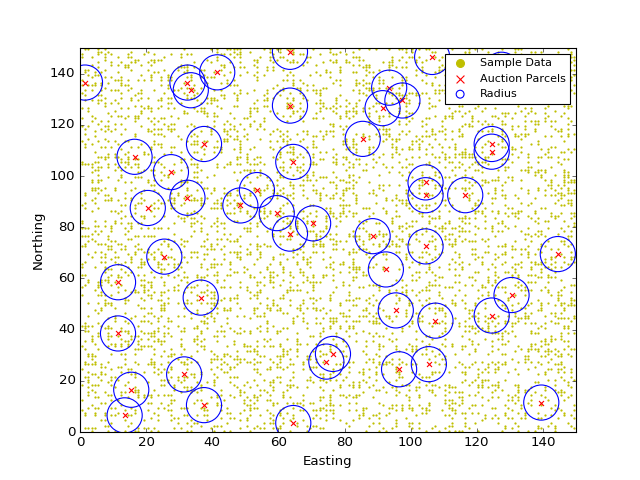

In [9]:
plt.gca().set_autoscale_on(False)
plt.axis([0.0, 150.0, 0.0, 150.0])
plt.scatter(sample_data.Easting, sample_data.Northing, s=1, color='y', label='Sample Data')
plt.scatter(auction_parcels.Easting, auction_parcels.Northing, marker='x', color='r', label='Auction Parcels')
plt.scatter(auction_parcels.Easting, auction_parcels.Northing, s=1000, facecolors='none', edgecolors='b', label='Radius')
lgnd = plt.legend(scatterpoints=1, fontsize=10)
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]
plt.xlabel('Easting')
plt.ylabel('Northing')

In [12]:
def estimate_gold(radius):
    gold_estimations = []
    for idx_ap, ap in auction_parcels.iterrows():
        sum = 0
        count = 0
        for idx_sd, sd in sample_data.iterrows():
            if (radius >= np.linalg.norm(np.array([sd['Easting'], sd['Northing']]) - np.array([ap['Easting'], ap['Northing']]))):
                sum += sd['gold_available']
                count += 1
        sum = sum / count if count > 0 else 0
        estimated_gold_column = 'estimated_gold_r{:d}'.format(radius)
        included_samples_column = 'included_samples_r{:d}'.format(radius)
        gold_estimations.append({'parcel_id': ap['parcel_id'], estimated_gold_column: sum, included_samples_column: count})
    return gold_estimations

In [13]:
gold_estimations = auction_parcels.loc[:,['parcel_id']]
for radius in range(1, 10):
    gold_estimations = gold_estimations.merge(pd.DataFrame(estimate_gold(radius)), on='parcel_id')
    
gold_estimations

,parcel_id,estimated_gold_r1,included_samples_r1,estimated_gold_r2,included_samples_r2,estimated_gold_r3,included_samples_r3,estimated_gold_r4,included_samples_r4,estimated_gold_r5,included_samples_r5,estimated_gold_r6,included_samples_r6,estimated_gold_r7,included_samples_r7,estimated_gold_r8,included_samples_r8,estimated_gold_r9,included_samples_r9
0,515,8430.11,1,13168.56,4,16190.58,6,16494.78,9,15915.63,15,15393.42,22,15690.17,30,14702.80,36,13949.57,44
1,914,24700.44,1,14531.39,4,15582.80,6,14144.52,11,13606.70,16,14756.13,18,14600.23,26,13677.95,35,13725.51,46
2,1538,9408.78,1,10292.52,4,15627.27,7,13899.16,11,13216.88,16,13283.81,20,11782.28,28,11652.88,40,11685.16,52
3,1790,17702.74,1,17702.74,1,8560.63,4,9413.39,8,8775.94,13,10102.08,18,11188.92,30,12018.55,40,11946.98,53
4,2416,20295.74,1,15225.96,4,15832.77,8,14422.47,13,14549.92,15,16149.23,22,15528.10,30,15456.95,42,14541.80,49
5,3332,11883.47,1,14105.59,4,13876.81,8,13151.41,11,13767.57,20,12742.37,29,12177.57,39,11300.35,50,10915.65,62
6,3697,9593.29,2,11602.23,6,9605.71,9,10314.71,12,11013.78,19,11581.40,23,10860.98,31,10890.04,39,11560.53,54
7,4006,0.00,0,10881.76,1,8551.74,3,11547.55,7,11566.03,17,10878.92,23,11765.73,29,11889.88,35,12261.89,46
8,4125,18885.74,1,18885.74,1,11337.85,4,9482.24,9,9874.56,16,11334.35,28,12214.98,39,12536.73,52,12852.20,59
9,4577,0.00,0,12185.13,2,12886.61,5,11929.91,9,10974.56,19,11997.18,26,11992.95,33,11848.74,39,12555.18,53


# Radius = 3 seems to fit the bill

# Compute the total extraction costs and estimated profit

In [16]:
total_costs = gold_estimations.loc[:, ['parcel_id', 'estimated_gold_r3']]

total_costs = total_costs.merge(elevation_data.loc[:, ['parcel_id', 'elevation']], on='parcel_id')

total_costs['total_cost'] = total_costs.apply(lambda row: fixed_cost(row), axis = 1) + total_costs.apply(lambda row: variable_cost(row), axis = 1)

total_costs['estimated_profit'] = total_costs.apply(lambda row: gold_price * row['estimated_gold_r3'] - row['total_cost'], axis = 1)

total_costs.sort_values(by=['estimated_profit'])

,parcel_id,estimated_gold_r3,elevation,total_cost,estimated_profit
7,4006,8551.74,1128.92,8548726.75,4278886.02
28,13905,6880.99,-334.67,4048496.39,6272989.40
39,18992,10048.37,709.52,8446713.16,6625847.41
47,21278,10562.88,656.77,8358826.14,7485493.61
30,14154,10862.17,933.84,8501277.14,7791977.14
45,20433,10986.68,784.49,8464949.67,8015076.45
20,10905,11739.21,583.50,8329169.47,9279646.85
3,1790,8560.63,474.18,3284920.47,9556019.52
13,7146,9426.45,-157.97,4120855.66,10018817.00
16,8712,12411.88,1007.17,8519111.23,10098713.70


# Select top 5 most promising parcels that also match Kevin's predictions

In [17]:
# Parcel IDs from Kevin: [7837, 19114, 20194, 11489,10905,1790,13249,14154,12810,11614,12221]

selected_parcels = [19114, 20194, 11489, 11614, 12810]

selected_total_costs = total_costs.loc[total_costs.parcel_id.isin(selected_parcels), :].sort_values(by=['estimated_profit'])

selected_total_costs

,parcel_id,estimated_gold_r3,elevation,total_cost,estimated_profit
21,11489,15386.50,-390.65,4025575.76,19054177.21
40,19114,16367.82,496.51,3293960.39,21257774.74
22,11614,16338.16,266.58,3200895.25,21306340.94
43,20194,16484.74,413.19,3260236.74,21466877.59
24,12810,18371.89,-296.70,4064047.21,23493789.95


# Remove the total costs from the available budget

In [20]:
total_cost = selected_total_costs.total_cost.sum()

bid_money = total_budget - total_cost

bid_money

32155284.65558866

# Place bids using an empiric "Gauss Distribution"
- Offer 7 million for the middle 3 parcels
- Divide the rest evenly for the remaining 2

In [58]:
bids = selected_total_costs.loc[:, ['parcel_id']]

max_bid = 7000000
remaining_money = bid_money - (max_bid * 3)

bids['bid_amount'] = pd.Series([remaining_money / 2, max_bid, max_bid, max_bid, remaining_money / 2]).values

bids

,parcel_id,bid_amount
21,11489,5577642.33
40,19114,7000000.00
22,11614,7000000.00
43,20194,7000000.00
24,12810,5577642.33


In [62]:
bids.to_csv("kevin_mihai.csv", cols=['parcel_id', 'bid_amount'], index=False)